# Challenge: Build your own NLP model


For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

Data cleaning / processing / language parsing

Create features using two different NLP methods: For example, BoW vs tf-idf.

Use the features to fit supervised learning models for each feature set to predict the category outcomes.

Assess your models using cross-validation and determine whether one model performed better.

Pick one of the models and try to increase accuracy by at least 5 percentage points.

Write up your report in a Jupyter notebook. Be sure to explicitly justify the choices you make throughout, and submit it below.

In [255]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import requests
from sklearn.feature_extraction.text import TfidfVectorizer


## PLOS Abstracts

I downloaded the absracts using the link below.I was looking to use json files so used these

In [256]:

response_phy = requests.get(r'http://api.plos.org/search?q=title:"physics"&fl=abstract&wt=json&api_key=7ujScsFm2osdMw6ozx4g')
response_stars = requests.get(r'http://api.plos.org/search?q=title:"stars"&fl=abstract&wt=json&api_key=7ujScsFm2osdMw6ozx4g')
response_bh = requests.get(r'http://api.plos.org/search?q=title:"black holes"&fl=abstract&wt=json&api_key=7ujScsFm2osdMw6ozx4g')



## Data Cleaning and Preprocessing

In [257]:
physics_raw = response_phy.json()
stars_raw = response_stars.json()
black_raw = response_bh.json()


def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    #text = re.sub(r'--',' ',text)
    text = re.sub(r'[\[\]]', '', text)
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'[\']', '', text)
    text = re.sub(r'[\\]', '', text)
    text = re.sub(r'\d', '', text)
    #text = ' '.join(text.split())
    return text



In [258]:
physics = ''
for article in physics_raw['response']['docs']:
    art = str(article['abstract'])
    physics = physics + text_cleaner(art)

physics[0:200]


'Background: Physical function is a crucial factor in the prevention and treatment of health conditions in older adults and is usually measured objectively with physical performance tests and/or physic'

In [259]:
stars=''
for article in stars_raw['response']['docs']:
    art = str(article['abstract'])
    stars = stars + text_cleaner(art)
stars[0:200]

'"n        The founding director of Singapores Institute of Molecular and Cell Biology illustrates the rise of science in Asia.n      "nAn extensive  mass mortality event along the West Coast of North '

In [260]:
black=''
for article in black_raw['response']['docs']:
    art = str(article['abstract'])
    black = black + text_cleaner(art)
black[0:200]

'nIt has been suggested that innovations occur mainly by combination: the more inventions accumulate, the higher the probability that new inventions are obtained from previous designs. Additionally, it'

In [261]:
nlp = spacy.load('en')
physics_doc = nlp(physics)
stars_doc = nlp(stars)
black_doc=nlp(black)

In [262]:

physics_sents = [[sent, 'Physics'] for sent in physics_doc.sents]
stars_sents = [[sent, 'Stars'] for sent in stars_doc.sents]
black_sents = [[sent, 'Black Holes'] for sent in black_doc.sents]


sentences = pd.DataFrame(physics_sents + stars_sents + black_sents)
sentences.head()

,0,1
0,"(Background, :, Physical, function, is, a, cru...",Physics
1,"(Objective, :)",Physics
2,"(To, examine, whether, ), physical, performanc...",Physics
3,"(Design, :, Cross, -, sectional, study, to, ex...",Physics
4,"(Methods, :)",Physics


As seen above since  spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur. We will exclude stopwords and punctuation. In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

# BOW(Bag of Words)

In [263]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_punct
               and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(1000)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:,common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_ 
                for token in sentence
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%100 == 0:
            print('Processing row {}'.format(i))
    return df


# Set up the bags.
physics = bag_of_words(physics_doc)
stars = bag_of_words(stars_doc)
black = bag_of_words(black_doc)

# Combine bags to create a set of unique words.
common_words = set(physics + stars + black)

In [240]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200


,natural,this,secondary,type,investigate,systemic,nutrition,emergence,prevent,institute,...,physical,draw,capability,previously,impede,mask,functionaliz,methodological,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,"(Background, :, Physical, function, is, a, cru...",Physics
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Objective, :)",Physics
2,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,"(To, examine, whether, ), physical, performanc...",Physics
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Design, :, Cross, -, sectional, study, to, ex...",Physics
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Methods, :)",Physics


Now we have got all the features.So, let's give the bag of words features a whirl by trying a random forest.

### Random Forest

In [264]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9666666666666667

Test set score: 0.6732673267326733


### Cross Validation

In [265]:
from sklearn.model_selection import cross_val_score
print("Training data accuracy for Random Forest: ",cross_val_score(rfc, X_train, y_train, cv=10))
print("Testing data accuracy Random Forest: ",cross_val_score(rfc, X_test, y_test, cv=10))

Training data accuracy for Random Forest:  [0.625      0.75       0.6875     0.6875     0.75       0.6875
 0.64285714 0.64285714 0.84615385 0.69230769]
Testing data accuracy Random Forest:  [0.66666667 0.5        0.54545455 0.63636364 0.5        0.55555556
 0.77777778 0.55555556 0.55555556 0.55555556]


### Logistic Regression

In [266]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.9933333333333333

Test set score: 0.8217821782178217


### Cross Validation

In [267]:
from sklearn.model_selection import cross_val_score
print("Training data accuracy for LogisticRegression: ",cross_val_score(lr, X_train, y_train, cv=10))
print("Testing data accuracy for LogisticRegression: ",cross_val_score(lr, X_test, y_test, cv=10))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defau

Training data accuracy for LogisticRegression:  [0.875      0.8125     0.875      0.8125     0.875      0.75
 0.71428571 0.78571429 0.84615385 0.84615385]


C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defau

Testing data accuracy for LogisticRegression:  [0.75       0.91666667 0.72727273 0.63636364 0.8        0.66666667
 0.88888889 0.88888889 0.77777778 0.77777778]


### Gradient Boosting

In [268]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9933333333333333

Test set score: 0.7326732673267327


### Cross Validation Score

In [269]:
print("Training data accuracy for GradientBoostingClassifier: ",cross_val_score(clf, X_train, y_train, cv=10))
print("Testing data accuracy for GradientBoostingClassifier: ",cross_val_score(clf, X_test, y_test, cv=10))

Training data accuracy for GradientBoostingClassifier:  [0.9375     0.75       0.875      0.8125     0.875      0.75
 0.57142857 0.78571429 0.84615385 0.76923077]
Testing data accuracy for GradientBoostingClassifier:  [0.83333333 0.83333333 0.54545455 0.72727273 0.6        0.66666667
 0.77777778 0.77777778 0.66666667 0.77777778]


We do observe that most of the model have overfitting in the training data.In test data, overfitting doesnot look to be a problem.Gradient boosting seems to be the winner for accuracy which is expected because it learn from its previous steps and tries to predict better.The downside of GBR is it takes lot of time to run because of its complex computations.Now lets use another NLP Method Tf-idf

# Tf-idf

In [272]:
abstract_list=[]
for topic in [physics_raw, stars_raw, black_raw]:
    for article in topic['response']['docs']:
     abstract_list = abstract_list + article['abstract']



In [273]:
from sklearn.feature_extraction.text import TfidfVectorizer
X=abstract_list
X_train, X_test = train_test_split(X, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(X_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])



Number of features: 371
Original sentence: 
        The roles of microRNAs (miRNAs) as important regulators of gene expression have been studied intensively. Although most of these investigations have involved the highly expressed form of the two mature miRNA species, increasing evidence points to essential roles for star-form microRNAs (miRNA*), which are usually expressed at much lower levels. Owing to the nature of miRNA biogenesis, it is challenging to use plasmids containing miRNA coding sequences for gain-of-function experiments concerning the roles of microRNA* species. Synthetic microRNA mimics could introduce specific miRNA* species into cells, but this transient overexpression system has many shortcomings. Here, we report that specific miRNA* species can be overexpressed by introducing artificially designed stem-loop sequences into short hairpin RNA (shRNA) overexpression vectors. By our prototypic plasmid, designed to overexpress hsa-miR-146b-3p, we successfully expressed hi

# Dimension Reduction

In [274]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 99.99999999999987
Component 0:
Background: Despite a consensus emerging that affirms that shorter epochs should be used in youth to correctly register physical activity levels in free-living conditions, little is known about its effect on children’s physical activity conducted in structured periods of time. This study analyzed the effect that epoch length (1, 2, 3, 5, 10, 15, 30 and 60s) may have on different physical activity intensities in physical education lessons. Methods: A sample of 1912 individual measures of physical education lessons were measured with a GT3X accelerometer. Data were collected from 1227 Swiss Elementary school students recruited in 17 elementary schools. PE lessons lasted from 45 minutes to one and a half hours. Data, originally collected in 1-s epoch, were then reintegrated into 2s, – 3s – 5s – 10s – 15s – 30s –60s epochs. Results: Longer epochs were associated with higher levels of light (F = 8197.6, p < .001), m

Name: 0, dtype: float64
Component 1:
\n        This review presents a comprehensive overview of the current status regarding the global diversity of the echinoderm class Ophiuroidea, focussing on taxonomy and distribution patterns, with brief introduction to their anatomy, biology, phylogeny, and palaeontological history. A glossary of terms is provided. Species names and taxonomic decisions have been extracted from the literature and compiled in The World Ophiuroidea Database, part of the World Register of Marine Species (WoRMS). Ophiuroidea, with 2064 known species, are the largest class of Echinodermata. A table presents 16 families with numbers of genera and species. The largest are Amphiuridae (467), Ophiuridae (344 species) and Ophiacanthidae (319 species). A biogeographic analysis for all world oceans and all accepted species was performed, based on published distribution records. Approximately similar numbers of species were recorded from the shelf (n = 1313) and bathyal depth 

Name: 1, dtype: float64
Component 2:
\n        As biomedical investigators strive to integrate data and analyses across spatiotemporal scales and biomedical domains, they have recognized the benefits of formalizing languages and terminologies via computational ontologies. Although ontologies for biological entities—molecules, cells, organs—are well-established, there are no principled ontologies of physical properties—energies, volumes, flow rates—of those entities. In this paper, we introduce the Ontology of Physics for Biology (OPB), a reference ontology of classical physics designed for annotating biophysical content of growing repositories of biomedical datasets and analytical models. The OPB's semantic framework, traceable to James Clerk Maxwell, encompasses modern theories of system dynamics and thermodynamics, and is implemented as a computational ontology that references available upper ontologies. In this paper we focus on the OPB classes that are designed for annotating physi

Name: 2, dtype: float64
Component 3:
\nDisease outbreaks can have substantial impacts on wild populations, but the often patchy or anecdotal evidence of these impacts impedes our ability to understand outbreak dynamics. Recently however, a severe disease outbreak occurred in a group of very well-studied organisms–sea stars along the west coast of North America. We analyzed nearly two decades of data from a coordinated monitoring effort at 88 sites ranging from southern British Columbia to San Diego, California along with 2 sites near Sitka, Alaska to better understand the effects of sea star wasting disease (SSWD) on the keystone intertidal predator, Pisaster ochraceus. Quantitative surveys revealed unprecedented declines of P. ochraceus in 2014 and 2015 across nearly the entire geographic range of the species. The intensity of the impact of SSWD was not uniform across the affected area, with proportionally greater population declines in the southern regions relative to the north. The 

Name: 3, dtype: float64
Component 4:
Background: STARS (STriated muscle Activator of Rho Signaling) is a sarcomeric protein expressed early in cardiac development that acts as an acute stress sensor for pathological remodeling. However the role of STARS in cardiac development and function is incompletely understood. Here, we investigated the role of STARS in heart development and function in the zebrafish model and in vitro. Methodology and Principal Findings: Expression of zebrafish STARS (zSTARS) first occurs in the somites by the 16 somite stage [17 hours post fertilization (hpf)]. zSTARS is expressed in both chambers of the heart by 48 hpf, and also in the developing brain, jaw structures and pectoral fins. Morpholino-induced knockdown of zSTARS alters atrial and ventricular dimensions and decreases ventricular fractional shortening (measured by high-speed video microscopy), with pericardial edema and decreased or absent circulation [abnormal cardiac phenotypes in 126/164 (77%) of 

Name: 4, dtype: float64


It looks like there is overfitting.Most features are related to each other.We cannot rely too much on this model since it has overfitting.Lets use a  heatmap to look at how similar various sentences are to one another.We can use first 10 sentences.It will give us an over all idea of how much sentences are similar to each other

# Sentence similarity


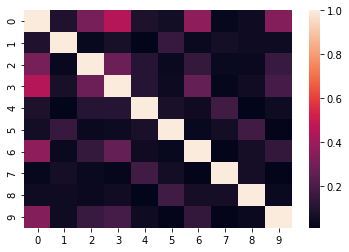

Key:
0 Background: Despite a consensus emerging that affirms that shorter epochs should be used in youth to correctly register physical activity levels in free-living conditions, little is known about its effect on children’s physical activity conducted in structured periods of time. This study analyzed the effect that epoch length (1, 2, 3, 5, 10, 15, 30 and 60s) may have on different physical activity intensities in physical education lessons. Methods: A sample of 1912 individual measures of physical education lessons were measured with a GT3X accelerometer. Data were collected from 1227 Swiss Elementary school students recruited in 17 elementary schools. PE lessons lasted from 45 minutes to one and a half hours. Data, originally collected in 1-s epoch, were then reintegrated into 2s, – 3s – 5s – 10s – 15s – 30s –60s epochs. Results: Longer epochs were associated with higher levels of light (F = 8197.6, p < .001), moderate (F = 2708.17, p < .001), and moderate-to-vigorous physical ac

      
5 
        The roles of microRNAs (miRNAs) as important regulators of gene expression have been studied intensively. Although most of these investigations have involved the highly expressed form of the two mature miRNA species, increasing evidence points to essential roles for star-form microRNAs (miRNA*), which are usually expressed at much lower levels. Owing to the nature of miRNA biogenesis, it is challenging to use plasmids containing miRNA coding sequences for gain-of-function experiments concerning the roles of microRNA* species. Synthetic microRNA mimics could introduce specific miRNA* species into cells, but this transient overexpression system has many shortcomings. Here, we report that specific miRNA* species can be overexpressed by introducing artificially designed stem-loop sequences into short hairpin RNA (shRNA) overexpression vectors. By our prototypic plasmid, designed to overexpress hsa-miR-146b-3p, we successfully expressed high levels of hsa-miR-146b-3p witho

In [275]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

As noticed above, there is very low similarity which means there are not many similar words being used in the sentences.That is an interesting thing to know

### Pick one of the models and try to increase accuracy by at least 5 percentage points.

## BOW(Bag of Words)


In [276]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_punct
               and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(500)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:,common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_ 
                for token in sentence
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%100 == 0:
            print('Processing row {}'.format(i))
    return df


# Set up the bags.
physics = bag_of_words(physics_doc)
stars = bag_of_words(stars_doc)
black = bag_of_words(black_doc)

# Combine bags to create a set of unique words.
common_words = set(physics + stars + black)

In [277]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200


,hypothesis,accord,general,varimax,crucial,triadic,connectivity,±,street,paper,...,wide,assessment,pp,heterogeneous,long,survey,functional,table,text_sentence,text_source
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Background, :, Physical, function, is, a, cru...",Physics
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Objective, :)",Physics
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,"(To, examine, whether, ), physical, performanc...",Physics
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,"(Design, :, Cross, -, sectional, study, to, ex...",Physics
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Methods, :)",Physics


### Random Forest

In [278]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.96

Test set score: 0.7029702970297029


Changing the most common feature to 500 did  make it little better.Lets try out ignoring  punctuation criteria and lets check for the below and increase the common words to 2000

### Bag of Words(BOW)

In [289]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:,common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_ 
                for token in sentence
                if (
                     not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%100 == 0:
            print('Processing row {}'.format(i))
    return df


# Set up the bags.
physics = bag_of_words(physics_doc)
stars = bag_of_words(stars_doc)
black = bag_of_words(black_doc)

# Combine bags to create a set of unique words.
common_words = set(physics + stars + black)

In [290]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200


,",",natural,this,secondary,type,investigate,systemic,nutrition,emergence,prevent,...,physical,draw,capability,previously,impede,mask,functionaliz,methodological,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,"(Background, :, Physical, function, is, a, cru...",Physics
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Objective, :)",Physics
2,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,"(To, examine, whether, ), physical, performanc...",Physics
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Design, :, Cross, -, sectional, study, to, ex...",Physics
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Methods, :)",Physics


In [291]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9733333333333334

Test set score: 0.7425742574257426


It looks like the overfitting is reduced a little and accuracy better better.For getting this result, we had to include  punctuations in the data as well

### Cross Validation

In [292]:
from sklearn.model_selection import cross_val_score
print("Training data accuracy for Random Forest: ",cross_val_score(rfc, X_train, y_train, cv=10))
print("Testing data accuracy Random Forest: ",cross_val_score(rfc, X_test, y_test, cv=10))

Training data accuracy for Random Forest:  [0.8125     0.6875     0.625      0.6875     0.875      0.625
 0.64285714 0.78571429 0.84615385 0.61538462]
Testing data accuracy Random Forest:  [0.66666667 0.66666667 0.54545455 0.54545455 0.5        0.55555556
 0.77777778 0.55555556 0.55555556 0.66666667]


# Conclusion:

In the above, there are few things we have done.We used 2 methods-bow and tf-idf and checked the accuracy of model.There has been some overfitting in the models which means its too close to the data points which should not happen.One way to resolve this is to add more data , but since it will slow down our process thats why I am not adding more data.Testing data performed ok so the models are not too bad.Also like we used tf-idf, the sentences are very less similar to each other thats good for analysis.In order to increase the performance , we tried to decrease the most common words to 500, it didnt make much of difference  but when I ignored punctuation criteria i.e include punctuation and increased the most common words to 2000 ,it did improve the accuracy results.